# Libraries

In [1]:
from functions import *
import shapely as sh
import scipy as sc

# Select dataset

In [2]:
div = 2
df = sort_contours_using_uniform_pdf_and_group("dataset_contours_aggregate_by_patch.csv", "dataset_contours_aggregate_by_patch.json", 4, div)
df

,image_name,"x coordinate in 0,0","y coordinate in 0,0",diameter (px),diameter (mm),area (px),area (mm2),group by diameter (px)
0,01_18.png,"[-8.134256960307198, -9.134256960307198, -10.1...","[-77.32207766411739, -76.32207766411739, -76.3...",153.854324,4.615630,10069.0,9.06210,1
1,01_300.png,"[12.809436307625788, 11.809436307625788, 10.80...","[-71.55207263686975, -70.55207263686975, -70.5...",141.671936,4.250158,9251.5,8.32635,1
2,01_344.png,"[-40.41439788891029, -40.41439788891029, -40.4...","[-40.55889167793009, -39.55889167793009, -38.5...",107.764557,3.232937,5179.0,4.66110,2
3,01_253.png,"[-6.219845513963264, -7.219845513963264, -8.21...","[-8.593582887700563, -7.593582887700563, -6.59...",24.351791,0.730554,280.5,0.25245,2


In [3]:
color = [
            '#3a7b9f', '#d4e2c3', '#f0119b', '#a1c935', "#28f8a1",
            '#ff9000', '#b04c87', '#52e0ff', '#6012ff', '#c0ffee',
            '#123456', '#654321', '#ff00ff', '#00ff00', '#0000ff',
            '#abcdef', '#fedcba', '#a0b1c2', '#1f2e3d', '#f0f8ff', '#3a7b9f',    
        ]

0
1
0
1


ValueError: cannot convert float NaN to integer

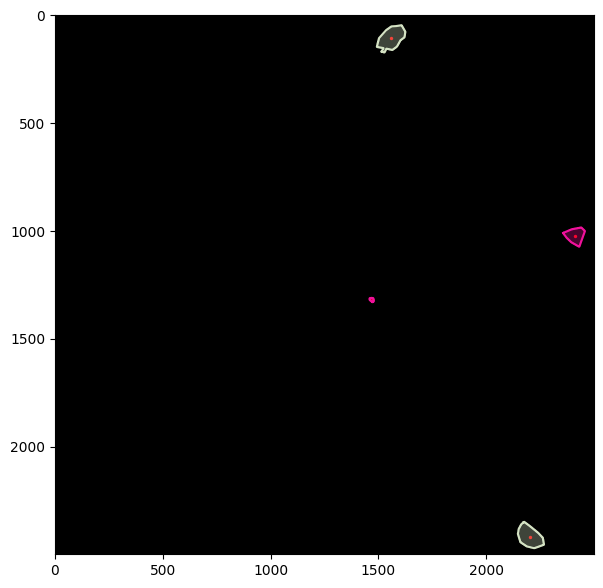

In [4]:
img_w, img_h = 2500, 2500
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(np.ones((img_h, img_w)), cmap="gray")
for k in [1, 2, 3, 4, 5]:# , div+1):
    df_group = df[df['group by diameter (px)'] == k].reset_index(drop=True)
    target_size = df_group['diameter (px)'].max() + 50
    nx = int(round(img_w / target_size))
    ny = int(round(img_h / target_size))
    cell_w = img_w / nx
    cell_h = img_h / ny
    centers = []
    ids = []
    if k > 1:
        quad_contours = []
    for j in range(ny):
        for i in range(nx):
            cx = (i + 0.5) * cell_w
            cy = (j + 0.5) * cell_h
            centers.append((cx, cy))
            ids.append(j * nx + i)
            if k > 1:
                # quad_contours.append([(cx - cell_w / 2, cy - cell_h / 2), (cx + cell_w / 2, cy - cell_h / 2), (cx + cell_w / 2, cy + cell_h / 2), (cx - cell_w / 2, cy + cell_h / 2)])
                n = 5
                quad_contours.append([(cx - (cell_w-n) / 2, cy - (cell_h-n) / 2), (cx + (cell_w-n) / 2, cy - (cell_h-n) / 2), (cx + (cell_w-n) / 2, cy + (cell_h-n) / 2), (cx - (cell_w-n) / 2, cy + (cell_h-n) / 2)])
    center_ids_selected = np.random.choice(ids, size=len(df_group), replace=False)
    centers = np.array(centers)

    # Check colision
    if k > 1:
        colision_bin = [0] * len(quad_contours)
        for i, quad in enumerate(quad_contours):
            quad_poly = sh.geometry.Polygon(quad)
            for cont in contours:
                if quad_poly.intersects(sh.geometry.Polygon(cont)):
                    colision_bin[i] = 1
                    break
        ids_temp = [i for i in range(len(quad_contours)) if colision_bin[i] == 0]
        if len(ids_temp) < len(df_group):
            center_ids_selected = np.random.choice(ids_temp, size=len(ids_temp), replace=False)
        else:
            center_ids_selected = np.random.choice(ids_temp, size=len(df_group), replace=False)

    if k == 4:
        for i in range(nx + 1):
            x = i * cell_w
            ax.axvline(x, color='blue', linewidth=1)
        for j in range(ny + 1):
            y = j * cell_h
            ax.axhline(y, color='blue', linewidth=1)
    if k <= 1:
        contours = []
    for m, row in df_group.iterrows():
        print(m)
        x_df = row['x coordinate in 0,0']
        y_df = row['y coordinate in 0,0']
        cx, cy = centers[center_ids_selected[m], 0], centers[center_ids_selected[m], 1]
        cx_noise = noise_point([cx], value_noise=1)
        cy_noise = noise_point([cy], value_noise=1)
        ax.scatter(cx_noise, cy_noise, c='red', s=2)
        x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
        contours.append(list(zip(x_new, y_new)))
        ax.plot(x_new, y_new, color[k])
        ax.fill(x_new, y_new, color[k], alpha=0.3)
plt.show()

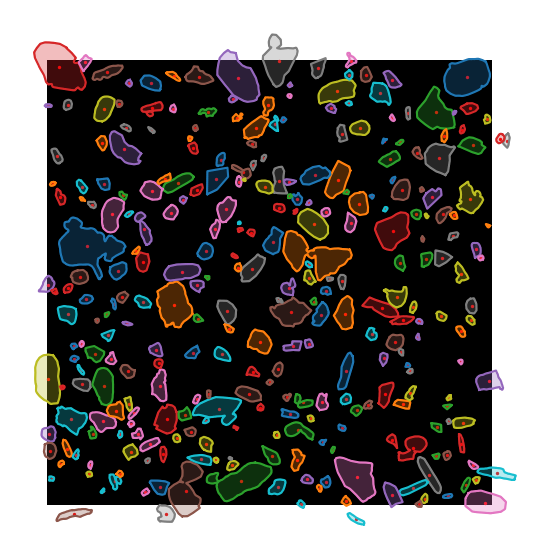

In [ ]:
div = 20
df = sort_contours_using_uniform_pdf_and_group("dataset_contours_aggregate_by_patch.csv", "dataset_contours_aggregate_by_patch.json", 300, div)
img_w, img_h = 2450, 2450
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(np.ones((img_h, img_w)), cmap="gray")
contours = []
collision_control = []
for m, row in df.iterrows():
    # print("m:", m)
    if m < int(1):
        n = 1
        sampler = sc.stats.qmc.LatinHypercube(d=2)
        sample = sampler.random(n=n)
        centroids = sc.stats.qmc.scale(sample, [0, 0], [img_w, img_h])
        x_df = row['x coordinate in 0,0']
        y_df = row['y coordinate in 0,0']
        cx, cy = centroids[0, 0], centroids[0, 1]
        cx_noise = noise_point([cx], value_noise=1)
        cy_noise = noise_point([cy], value_noise=1)
        x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
        current_contour = list(zip(x_new, y_new))
        contours.append(current_contour)
        ax.scatter(cx_noise, cy_noise, c='red', s=2)
        ax.plot(x_new, y_new)
        ax.fill(x_new, y_new, alpha=0.3)
    else:
        th = True
        max_iter = 0
        while th and max_iter < 10:
            # print("max_iter:", max_iter)
            n = 1
            sampler = sc.stats.qmc.LatinHypercube(d=2)
            sample = sampler.random(n=n)
            centroids = sc.stats.qmc.scale(sample, [0, 0], [img_w, img_h])
            x_df = row['x coordinate in 0,0']
            y_df = row['y coordinate in 0,0']
            cx, cy = centroids[0, 0], centroids[0, 1]
            cx_noise = noise_point([cx], value_noise=5)
            cy_noise = noise_point([cy], value_noise=5)
            x_new, y_new = trans_rota_polygon(x_df, y_df, cx_noise[0], cy_noise[0], angle=np.random.uniform(0, 360))
            current_contour = list(zip(x_new, y_new))
            for _, quad in enumerate([current_contour]):
                quad_poly = sh.geometry.Polygon(quad)
                for cont in contours:
                    th = quad_poly.intersects(sh.geometry.Polygon(cont))
                    # print("th:", th)
                    if th:
                        # print("Collision detected, retrying...")
                        break
            if th==False:
                # print("passei aqui no False th...")
                contours.append(current_contour)
                ax.scatter(cx_noise, cy_noise, c='red', s=2)
                ax.plot(x_new, y_new)
                ax.fill(x_new, y_new, alpha=0.3)
                break
            else:
                # print("Another try...")
                pass
            max_iter += 1
ax.axis('off')  # Remove os eixos (opcional)
plt.savefig(
    'output_image.png',  # Nome do arquivo (salvo na raiz do projeto)
    dpi=600,            # Resolução (ajuste para controlar qualidade/tamanho)
    bbox_inches='tight', # Remove bordas brancas
    pad_inches=0,       # Remove espaçamento extra
    transparent=True    # Fundo transparente (opcional)
)

# Exibe a imagem (opcional, pode remover se quiser apenas salvar)
plt.show()

In [37]:
len(contours)

300

# Gross section generator

In [ ]:
# generate_canvas_from_json("dataset_contours_aggregate_by_patch.json", (2500, 2500), 300)